<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/AE%20EEG%20epilepsy%20classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Autoencoder Model for Unsupervised Anomaly Detection (Healthy vs Seizure)

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from os import listdir

#обратите внимание - надо указать путь до своей папки на гугл-диске
os.chdir('/content/drive/MyDrive/edf_process/CNN_NN_learning')

In [15]:
# --- 1. Data Loading Functions ---

def load_images_by_class(image_dir, target_size, class_label_to_load):
    """Loads images belonging to a specific class."""
    images = []
    class_path = os.path.join(image_dir, class_label_to_load)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = tf.keras.utils.load_img(img_path, color_mode='rgb', target_size=target_size) # Ensure RGB
            img_array = tf.keras.utils.img_to_array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    images = np.array(images)
    print(f"Loaded {images.shape[0]} images from '{class_label_to_load}' class.")
    return images

def display_samples(X, num_samples=5, title="Sample Images"):
    """Displays a grid of sample images."""
    if len(X) < num_samples:
        num_samples = len(X)

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    if num_samples == 1:
        axes = [axes]
    for i in range(num_samples):
        # Scale pixel values back to [0, 255] before casting to uint8 for display
        axes[i].imshow((X[i] * 255).astype("uint8"))
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# --- 2. Autoencoder Model Definition ---
def create_autoencoder(input_shape):
    """Creates a convolutional autoencoder model."""

    # Encoder
    encoder_input = Input(shape=input_shape, name="encoder_input")

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x) # Bottleneck layer

    # Decoder path for the full autoencoder
    x_decoder_path = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x_decoder_path = BatchNormalization()(x_decoder_path)
    x_decoder_path = UpSampling2D((2, 2))(x_decoder_path)

    x_decoder_path = Conv2D(64, (3, 3), activation='relu', padding='same')(x_decoder_path)
    x_decoder_path = BatchNormalization()(x_decoder_path)
    x_decoder_path = UpSampling2D((2, 2))(x_decoder_path)

    x_decoder_path = Conv2D(32, (3, 3), activation='relu', padding='same')(x_decoder_path)
    x_decoder_path = BatchNormalization()(x_decoder_path)
    x_decoder_path = UpSampling2D((2, 2))(x_decoder_path)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x_decoder_path) # Output shape must match input, 3 channels for RGB

    # Full Autoencoder Model
    autoencoder = Model(encoder_input, decoded, name="autoencoder")

    # Separate Encoder Model (optional, for analysis)
    encoder = Model(encoder_input, encoded, name="encoder")

    # Separate Decoder Model (for analysis, using the same architecture as the decoder part of the autoencoder)
    decoder_input = Input(shape=encoded.shape[1:]) # Input to the decoder should match the output shape of the encoder

    _x = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder_input)
    _x = BatchNormalization()(_x)
    _x = UpSampling2D((2, 2))(_x)

    _x = Conv2D(64, (3, 3), activation='relu', padding='same')(_x)
    _x = BatchNormalization()(_x)
    _x = UpSampling2D((2, 2))(_x)

    _x = Conv2D(32, (3, 3), activation='relu', padding='same')(_x)
    _x = BatchNormalization()(_x)
    _x = UpSampling2D((2, 2))(_x)

    _decoded_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(_x)
    decoder = Model(decoder_input, _decoded_output, name="decoder")

    return autoencoder, encoder, decoder

Loading 'Healthy' images for training...
Loaded 153 images from 'Healthy' class.
Loaded 84 images from 'Seizure' class.
Training set size (Healthy): 137
Validation set size (Healthy): 16
Test set size (Seizure): 84


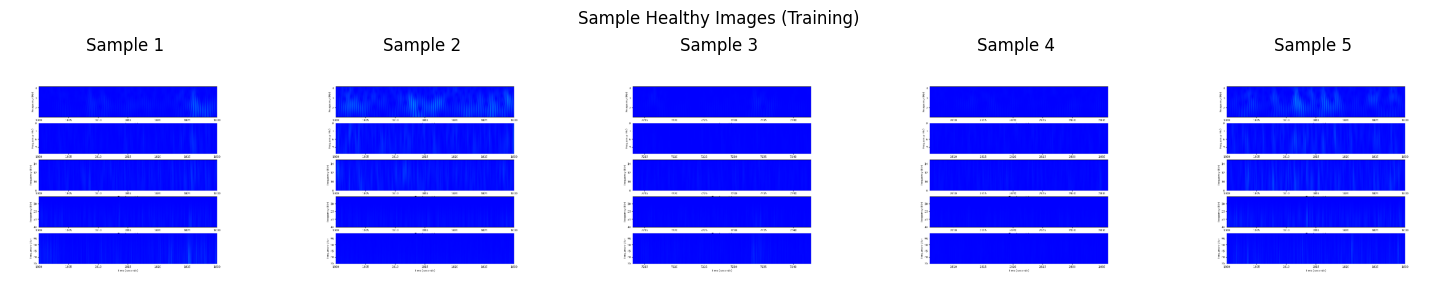

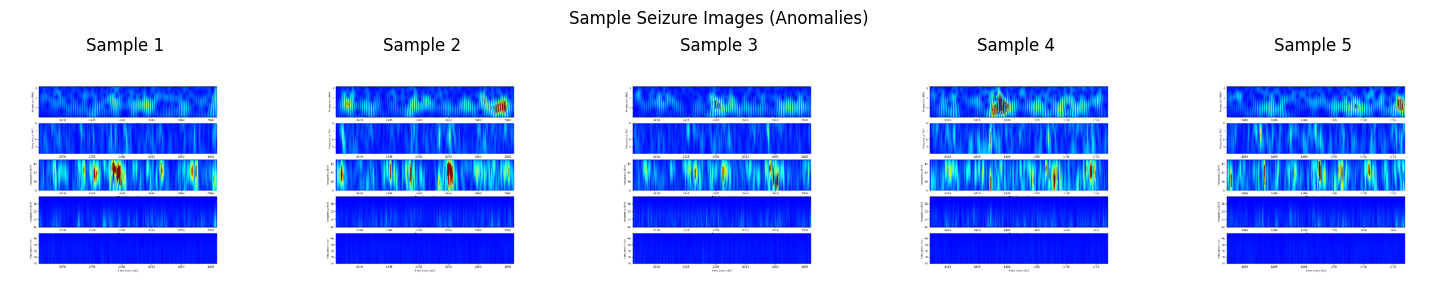

In [16]:
# --- 3. Main Execution ---

# Define paths and parameters
image_dir = '/content/drive/MyDrive/edf_process/CNN_NN_learning/wavelet_img/'
target_size = (512, 512)
input_shape = (*target_size, 3) # Assuming RGB images
batch_size = 8
epochs = 100 # Potentially need more epochs for unsupervised learning

# Change directory (optional, might not be needed depending on environment)
# os.chdir(image_dir)

print("Loading 'Healthy' images for training...")
X_healthy = load_images_by_class(image_dir, target_size, 'Healthy')
X_seizure = load_images_by_class(image_dir, target_size, 'Seizure')

if X_healthy.size == 0 or X_seizure.size == 0:
    raise ValueError("One or both classes ('Healthy', 'Seizure') could not be loaded or are empty.")

# Normalize pixel values to [0, 1]
X_healthy = X_healthy.astype('float32') / 255.0
X_seizure = X_seizure.astype('float32') / 255.0

# Shuffle the healthy data
X_healthy, _ = shuffle(X_healthy, np.arange(len(X_healthy)), random_state=24)

# Split healthy data into train and a small validation set for the autoencoder
X_healthy_train, X_healthy_val = train_test_split(X_healthy, test_size=0.1, random_state=42)

print(f"Training set size (Healthy): {X_healthy_train.shape[0]}")
print(f"Validation set size (Healthy): {X_healthy_val.shape[0]}")
print(f"Test set size (Seizure): {X_seizure.shape[0]}")

# Display samples
display_samples(X_healthy_train[:5], num_samples=5, title="Sample Healthy Images (Training)")
display_samples(X_seizure[:5], num_samples=5, title="Sample Seizure Images (Anomalies)")

In [17]:
epochs = 3 # Potentially need more epochs for unsupervised learning


# Create the autoencoder model
autoencoder_model, encoder_model, decoder_model = create_autoencoder(input_shape)
autoencoder_model.summary()

# Compile the autoencoder
autoencoder_model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae']) # MSE is common for reconstruction

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_autoencoder_weights.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train the autoencoder on Healthy images only
print("\n--- Training Autoencoder on 'Healthy' images ---")
history = autoencoder_model.fit(
    X_healthy_train, X_healthy_train, # Input and target are the same for autoencoders
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_healthy_val, X_healthy_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# --- 4. Evaluate Anomaly Detection Performance ---

# Reconstruct the validation set (should be low error)
reconstructions_val = autoencoder_model.predict(X_healthy_val, verbose=0)
reconstruction_errors_val = np.mean(np.square(X_healthy_val - reconstructions_val), axis=(1, 2, 3)) # MSE per image

# Reconstruct the seizure set (should be high error)
reconstructions_seizure = autoencoder_model.predict(X_seizure, verbose=0)
reconstruction_errors_seizure = np.mean(np.square(X_seizure - reconstructions_seizure), axis=(1, 2, 3))

# Combine errors and create labels for evaluation
all_errors = np.concatenate([reconstruction_errors_val, reconstruction_errors_seizure])
all_labels = np.concatenate([np.zeros(len(reconstruction_errors_val)), np.ones(len(reconstruction_errors_seizure))]) # 0=Normal, 1=Anomaly

# Determine a threshold for anomaly detection (e.g., using percentile or mean+std of val errors)
threshold_percentile = 95 # Example: Use 95th percentile of healthy val errors
threshold = np.percentile(reconstruction_errors_val, threshold_percentile)
print(f"\nUsing threshold at {threshold_percentile}th percentile of Healthy validation errors: {threshold:.6f}")

# Classify based on threshold
predicted_anomaly = (all_errors > threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(all_labels, predicted_anomaly)
roc_auc = roc_auc_score(all_labels, all_errors) # Using raw errors for AUC calculation
print("\n--- Evaluation Results ---")
print(f"Threshold ({threshold_percentile}th percentile): {threshold:.6f}")
print(f"Accuracy (based on threshold): {accuracy:.4f}")
print(f"ROC AUC Score (using reconstruction errors): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, predicted_anomaly, target_names=["Normal (Healthy)", "Anomaly (Seizure)"]))


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 512, 512, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,235 (1.28 MB)

 Trainable params: 334,595 (1.28 MB)

 Non-trainable params: 640 (2.50 KB)


--- Training Autoencoder on 'Healthy' images ---
Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.1401 - mae: 0.2714 
Epoch 1: val_loss improved from inf to 0.18523, saving model to best_autoencoder_weights.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 307s 16s/step - loss: 0.1380 - mae: 0.2682 - val_loss: 0.1852 - val_mae: 0.3543
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 0.0572 - mae: 0.1409 
Epoch 2: val_loss improved from 0.18523 to 0.06586, saving model to best_autoencoder_weights.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 312s 16s/step - loss: 0.0569 - mae: 0.1404 - val_loss: 0.0659 - val_mae: 0.1940
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 0.0348 - mae: 0.1040 
Epoch 3: val_loss improved from 0.06586 to 0.05581, saving model to best_autoencoder_weights.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 274s 15s/step - loss: 0.0347 - mae: 0.1037 - val_loss: 0.0558 - val_mae: 0.1733

Using threshold at 95th percentile of Healthy validation errors: 0.058750

--- Evaluation Results 

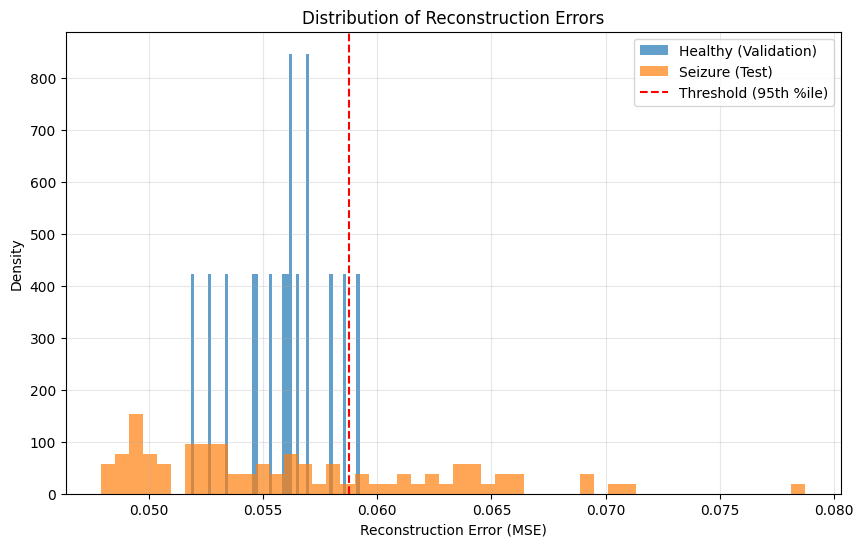

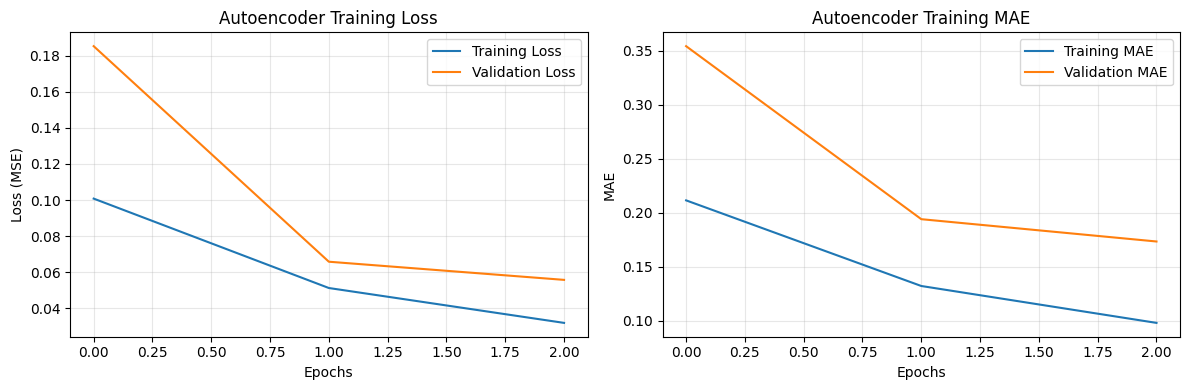

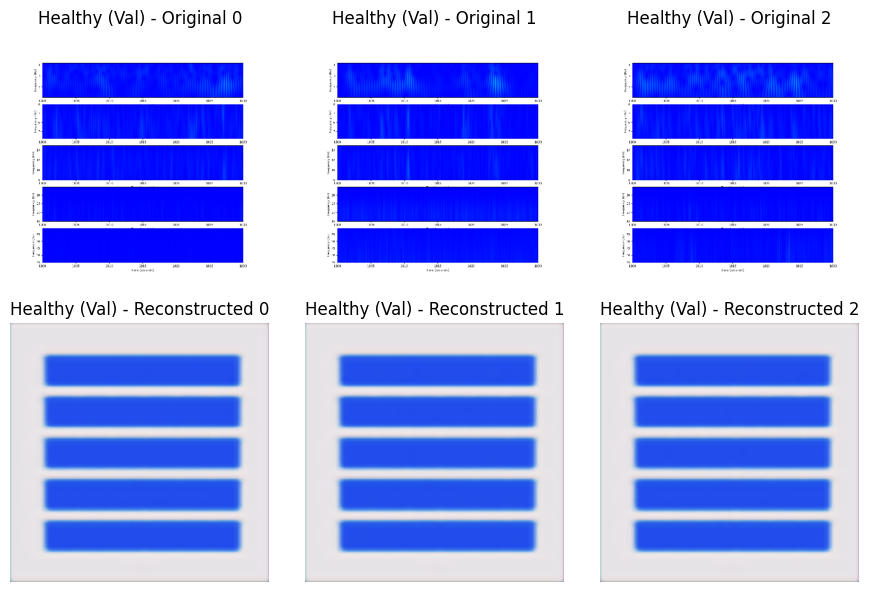

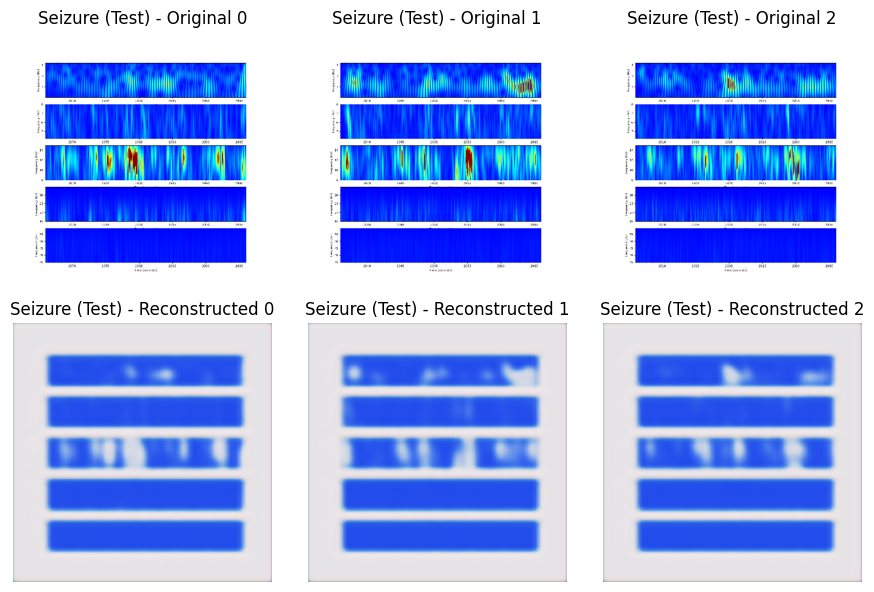

In [18]:

# --- 5. Visualizations ---

# Plot Reconstruction Errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors_val, bins=50, alpha=0.7, label='Healthy (Validation)', density=True)
plt.hist(reconstruction_errors_seizure, bins=50, alpha=0.7, label='Seizure (Test)', density=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold_percentile}th %ile)')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Autoencoder Training MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display some original vs reconstructed examples from both sets
def show_reconstructions(originals, reconstructions, title_prefix, num_samples=3):
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
    for i in range(min(num_samples, originals.shape[0])):
        # Original
        axes[0, i].imshow(originals[i])
        axes[0, i].set_title(f'{title_prefix} - Original {i}')
        axes[0, i].axis('off')
        # Reconstructed
        axes[1, i].imshow(reconstructions[i])
        axes[1, i].set_title(f'{title_prefix} - Reconstructed {i}')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Show examples from Healthy validation set
recon_val_examples = autoencoder_model.predict(X_healthy_val[:3], verbose=0)
show_reconstructions(X_healthy_val[:3], recon_val_examples, "Healthy (Val)")

# Show examples from Seizure test set
recon_seizure_examples = autoencoder_model.predict(X_seizure[:3], verbose=0)
show_reconstructions(X_seizure[:3], recon_seizure_examples, "Seizure (Test)")